In [6]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
from qiskit.aqua import QuantumInstance, run_algorithm
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle
from quantum_utils import circle_notation
import matplotlib.pyplot as plt
from math import pi
plt.style.use('ggplot')

Produce the Circuit of the following form.

[Tutorial](https://qiskit.org/textbook/ch-applications/satisfiability-grover.html)

```p cnf 4 6
1 -2 3 -4 0
1 -2 3 4 0
-1 0
1 4 0
-1 -3 4 0
-3 0```

This circuit represent the following SAT problem:
v1, v2, v3, v4

```(v1, not v2, v3, not v4) and 
(v1, not v2, v3, v4) and
(not v1) and
(v1, v4) and
(not v1, not v3, v4) and
(not v3)```

In [7]:
def set_bits(a, b):
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    if a == 1:
        qc.x(qr[0])
    if b == 1:
        qc.x(qr[1])
        
    return qc

def get_circle_notation(qc):
    backends = Aer.get_backend("statevector_simulator")
    job = execute(qc, backends)
    result = job.result()
    sv = result.get_statevector()
    circle_notation(sv, rows=1)
    return sv


In [50]:
def OR(qc, ctrl_idxs, tgt_idx):
    """ add or gate to qc at qubit q1 and q2 
    qc: QuantumRegister
    ctrl_idxs: list of int indices
    tgt_idx: int idx
    """
    qr = qc.qregs[0]
    aqr = qc.qregs[1]
    ctrl_qs = [qr[i] for i in ctrl_idxs]
    tgt_q = qr[tgt_idx]
    qc.x(ctrl_qs)
    qc.mct(ctrl_qs, tgt_q, aqr)
    qc.x(ctrl_qs+[tgt_q])
    qc.barrier()
    return qc

def OR_inv(qc, ctrl_idxs, tgt_idx):
    """ add or gate to qc at qubit q1 and q2 
    qc: QuantumRegister
    ctrl_idxs: list of int indices
    tgt_idx: int idx
    """
    qr = qc.qregs[0]
    aqr = qc.qregs[1]
    ctrl_qs = [qr[i] for i in ctrl_idxs]
    tgt_q = qr[tgt_idx]
    qc.x(ctrl_qs+[tgt_q])
    qc.mct(ctrl_qs, tgt_q, aqr)
    qc.x(ctrl_qs)
    qc.barrier()
    return qc

def NOT(qc, idxs):
    qr = qc.qregs[0]
    qs = [qr[i] for i in idxs]
    qc.x(qs)
    return qc
    
def build_qc(n_qubits, n_cbits):
    qr = QuantumRegister(n_qubits) 
    aqr = QuantumRegister(2)
    cr = ClassicalRegister(n_cbits) 
    qc = QuantumCircuit(qr, aqr, cr)
    return qc

def mirror(qc, qs):
    qc.h(qs)
    qc.x(qs)
    qc.mcrz(pi, qs[:-1], qs[-1])
    qc.x(qs)
    qc.h(qs)
    return qc
    

In [51]:
def solution():
    n_lit, n_clause = 4, 6
    qc = build_qc(n_lit+n_clause, n_lit)
    qr = qc.qregs[0]
    cr = qc.cregs[0]
    lits = qr[:n_lit]  # literals
    clauses = qr[n_lit:]
    qc.h(lits)
    
    # ----- COMPUTE -----
    # 1 -2 3 -4 0
    qc = NOT(qc, [1, 3])
    qc = OR(qc, [0, 1, 2, 3], 0+n_lit)
    qc = NOT(qc, [1, 3])
    
    # 1 -2 3 4 0
    qc = NOT(qc, [1])
    qc = OR(qc, [0, 1, 2, 3], 1+n_lit)
    qc = NOT(qc, [1])
    
    # -1 0
    qc = NOT(qc, [0])
    qc = OR(qc, [0], 2+n_lit)
    qc = NOT(qc, [0])

    # 1 4 0
    qc = OR(qc, [0, 3], 3+n_lit)

    # -1 -3 4 0
    qc = NOT(qc, [0, 2])
    qc = OR(qc, [0, 2, 3], 4+n_lit)
    qc = NOT(qc, [0, 2])

    # -3 0
    qc = NOT(qc, [2])
    qc = OR(qc, [2], 5+n_lit)
    qc = NOT(qc, [2])
    
    # phase z
    qc.mcrz(pi, clauses[:-1], clauses[-1])
    
    # ----- UNCOMPUTE ----- 
    
        # 1 -2 3 -4 0
    qc = NOT(qc, [1, 3])
    qc = OR_inv(qc, [0, 1, 2, 3], 0+n_lit)
    qc = NOT(qc, [1, 3])
    
    # 1 -2 3 4 0
    qc = NOT(qc, [1])
    qc = OR_inv(qc, [0, 1, 2, 3], 1+n_lit)
    qc = NOT(qc, [1])
    
    # -1 0
    qc = NOT(qc, [0])
    qc = OR_inv(qc, [0], 2+n_lit)
    qc = NOT(qc, [0])

    # 1 4 0
    qc = OR_inv(qc, [0, 3], 3+n_lit)

    # -1 -3 4 0
    qc = NOT(qc, [0, 2])
    qc = OR_inv(qc, [0, 2, 3], 4+n_lit)
    qc = NOT(qc, [0, 2])

    # -3 0
    qc = NOT(qc, [2])
    qc = OR_inv(qc, [2], 5+n_lit)
    qc = NOT(qc, [2])
    
    # ----- MIRROR -----
    qc = mirror(qc, lits)
    for i in range(len(cr)):
        qc.measure(qr[i], cr[i])
    
    return qc

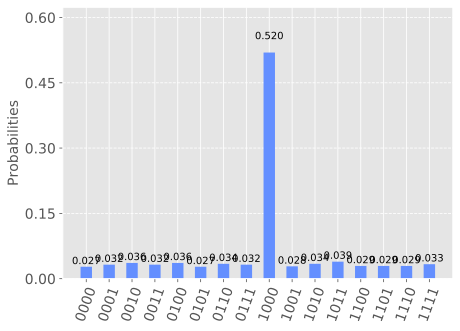

In [52]:
qc = solution()
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
plot_histogram(result.get_counts())

### Solution
---

In [53]:
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 4 6
1 -2 3 -4 0
1 -2 3 4 0
-1 0
1 4 0
-1 -3 4 0
-3 0
'''

In [54]:
oracle = LogicalExpressionOracle(input_3sat)
grover = Grover(oracle)

[-1, -2, -3, 4]


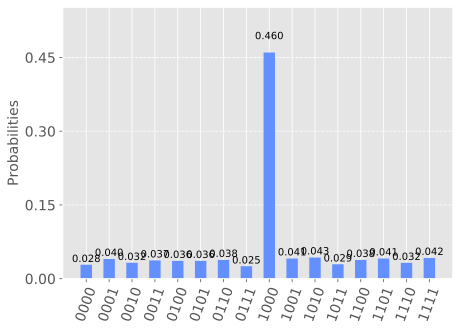

In [55]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = grover.run(quantum_instance)
print(result['result'])
plot_histogram(result['measurement'])

### I GOT IT!!